In [1]:
# First we need to import the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Here we check if a GPU is available to speed up the training process.
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda"
device = torch.device(device_name)
# f means formatted; it allows you to print out variables in-line.
print(f"Using device: {device}")

Using device: cpu


In [3]:
data_min_old = 0
data_max_old = 0

# RNN outputs data between -1 and 1, so we need to normalize (scale the data) between those values.
def normalize_data(data, min = -1, max = 1):
    global data_min_old, data_max_old
    arr = np.array(data)
    data_min_old = np.min(arr)
    data_max_old = np.max(arr)

    normalized = min + (arr - data_min_old) * (max - min) / (data_max_old - data_min_old)
    
    return normalized.tolist()

# test = [1, 14, 3, 4, 5]
# test = normalize_data(test)
# print(test)

# This restores the data back to it's original form
def inverse_normalize_data(data, min = -1, max = 1):
    normalized_arr = np.array(data)
    original_values = data_min_old + (normalized_arr - min) * (data_max_old - data_min_old) / (max-min)
    return original_values
    
# print(inverse_normalize_data(test))

In [4]:
# Here we create a function to prepare the input (allowing us to take a variety of data)
def create_sequences(data, sequence_length: int):
    data = normalize_data(data)
    xs = []
    ys = []

    for i in range(len(data) - sequence_length):
        # Get a chunk of data for our input sequence
        # In Python, a colon (:) within a subscript (square brackets []) is used for "slicing" sequences like lists and strings. 
        # It allows for extracting a portion of the sequence based on the specified start, stop, and step values.
        # For x, we start at i and goes up to i + the sequence length (exclusive) 
        x = data[i:(i+sequence_length)]
        # The next value of the data is our target that we want to predict
        y = data[i + sequence_length]
        # We append these values to our starting arrays
        xs.append(x)
        ys.append(y)

    # Now we have to convert our data to Tensors using from_numpy; we want to use the float datatype
    return torch.from_numpy(np.array(xs)).float(), torch.from_numpy(np.array(ys)).float() # Finally we return our inputs and outputs

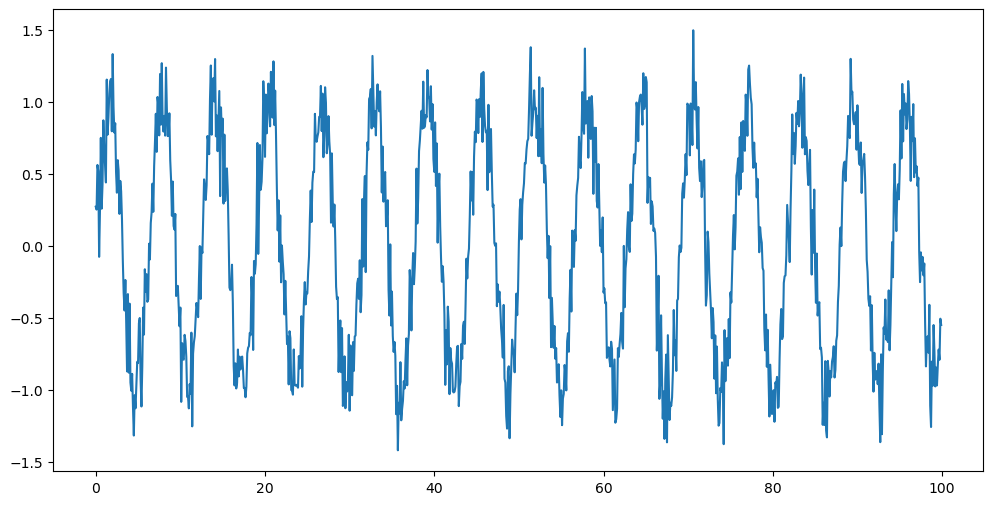

In [16]:
# Here we'll create some simple test data.
# As usual, we'll start with a numpy array and then convert it to a Tensor

# Generate a list of all the values between 0 and 100 with a step of 0.1
x_data = np.arange(0, 100, 0.1)

# Creating noise
mean = 0
std_dev = 0.2 # Adjust this value to control noise intensity (it is the deviation from the mean)
noise = np.random.normal(mean, std_dev, size=len(x_data))

# Our output data will be a sin wave with some added noise
y_data = np.sin(x_data) + noise

# Lets plot the data
plt.figure(figsize=(12, 6))
plt.plot(x_data, y_data)
plt.show()

In [17]:
# Now let's turn the sine wave into sequences of a certain length
sequence_length = 10
input_sequences, targets = create_sequences(y_data, sequence_length)

# unsqueeze adds a new dimension of size 1 at the end of the tensor's shape
# We do this because an RNN expects a sequence of vectors (right now we have a sequence of numbers).
input_sequences = input_sequences.unsqueeze(-1)
targets = targets.unsqueeze(-1)

In [18]:
# Use this function to load a custom dataset from a CSV file.
# If you use this, replace the values in the cell below this one with the output of this function.
# Currently untested
def load_and_prepare_data(file_path, column_name, sequence_length, train_split=0.8):
    """
    This function loads time-series data from a CSV, prepares it for an RNN,
    and splits it into training and testing sets.
    
    Parameters:
        file_path: The path to your CSV file (e.g., 'data/my_buildings.csv').
        column_name: The name of the column you want to use (e.g., 'energy_consumption').
        sequence_length: The number of past time steps to use for each prediction.
                               For hourly data, 24 would mean using the last 24 hours.
        train_split: The percentage of data to use for training (e.g., 0.8 for 80%).
        
    Returns:
        A tuple containing the training and testing data tensors for inputs and targets:
        (train_inputs, train_targets, test_inputs, test_targets)
    """
    
    print(f"--- Loading data from '{file_path}' ---")
    
    # We use the pandas library to read the data easily.
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")
        return None, None, None, None
    
    # We grab the values from the chosen column and convert them to a simple array.
    # We use .astype(float) to make sure our numbers are decimals, which is what PyTorch likes to work with.
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the CSV. Available columns are: {list(df.columns)}")
        return None, None, None, None
        
    data_series = df[column_name].values.astype(float)
    
    # This is the same 'create_sequences' function from our notebook.
    # It turns a long list of data into smaller (input, target) pairs.
    print(f"Creating sequences with a length of {sequence_length}...")

    input_sequences, targets = create_sequences(data_series, sequence_length)
    
    print(f"Total number of sequences created: {len(input_sequences)}")
    
    # An RNN expects data in a specific shape: (batch_size, sequence_length, number_of_features).
    # Since our data has only one feature (e.g., energy consumption), we add a new dimension to represent that single feature.
    print("Reshaping sequences for the RNN (adding a 'feature' dimension)")
    input_sequences = input_sequences.unsqueeze(-1)
    targets = targets.unsqueeze(-1)
    
    print(f"New shape of inputs: {input_sequences.shape}")
    
    # We split our data into a training and testing parts.
    print(f"Splitting data into a {train_split * 100}% training set...")
    train_size = int(train_split * len(input_sequences))
    
    train_inputs = input_sequences[:train_size].to(device)
    train_targets = targets[:train_size].to(device)
    
    test_inputs = input_sequences[train_size:].to(device)
    test_targets = targets[train_size:].to(device)
    
    print(f"Training samples: {len(train_inputs)}")
    print(f"Testing samples: {len(test_inputs)}")
    
    print("Data preparation complete!")
    
    # --- Step 6: Return the prepared data ---
    return train_inputs, train_targets, test_inputs, test_targets

In [19]:
# Now let's split our data into training and testing sets
# We'll use 80% for training and 20% for testings
train_size = int(0.8 * len(input_sequences))
# We'll slice the data and move it to the CPU or GPU 
# Both the model and the data need to be on the same device for processing.
train_inputs = input_sequences[:train_size].to(device)
train_targets = targets[:train_size].to(device)

test_inputs = input_sequences[train_size:].to(device)
test_targets = targets[train_size:].to(device)

print(f"Num of training samples: {len(train_inputs)}")
print(f"Num of testing samples: {len(test_inputs)}")

Num of training samples: 792
Num of testing samples: 198


In [20]:
# Here's where we build our custom RNN model.
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        # As usual we start with super to initialize the parent class
        super(RNNModel, self).__init__()

        # Store the hidden size for later
        self.hidden_size = hidden_size
        self.num_layers = 1
        
        # input_size is the number of features at each time step (e.g. 1 for a sine wave)
        # hidden_size is the number of neurons in the hidden middle layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # The final linear layer maps the RNN's output to the desired predictions
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # The RNN needs an initial hidden state, so we'll start with all zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Then we pass the input sequence and initial hidden state to the RNN
        # "out" is the output per each timestep
        # "hn" is the final hidden state after the last time step
        out, hn = self.rnn(x, h0)
        # Now we only care about the output of the last time step (we are predicting a single value based on a whole sequence)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
input_size = 1 # Only one input, the value of the data at a particular point
hidden_size = 50 # A pretty common choice for number of hidden layers
output_size = 1 # We are predicting one value

# Now we create an instance of our model and send it to our CPU/GPU
model = RNNModel(input_size, hidden_size, output_size).to(device)

# We define our loss function and optimizer
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
# This will store a list of our loss data so we can graph it later if we want.
loss_data = []

# We loop through 500 training sessions (epochs) here.
for epoch in range(500):
    # We set the model to training mode.
    model.train()
    
    # We generate a prediction from our x_data.
    predictions = model(train_inputs)

    # We compare the prediction to the known y_data and calculate its MSE.
    loss = criterion(predictions, train_targets)

    # Normally, the optimizer accumulates the gradient, but we don't want that. This is like zeroing a scale (resetting the gradient to zero).
    optimizer.zero_grad()
    # We backpropogate (go back through the layers to find the source of the loss.)
    loss.backward()
    # Then we apply what we learned in the backpropogation to update the model with new weights.
    optimizer.step()

    # Here we just append loss data if we want to graph it later.
    loss_data.append(loss.item())

    # Every hundreth epoch (the % means modulo, it gives the remainder), we print out the loss to see how our model is doing.
    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss {loss.item()}")

epoch 0, loss 0.2245066612958908
epoch 100, loss 0.02302408777177334
epoch 200, loss 0.022354958578944206
epoch 300, loss 0.022136270999908447
epoch 400, loss 0.022030076012015343



Test Loss: 0.0238


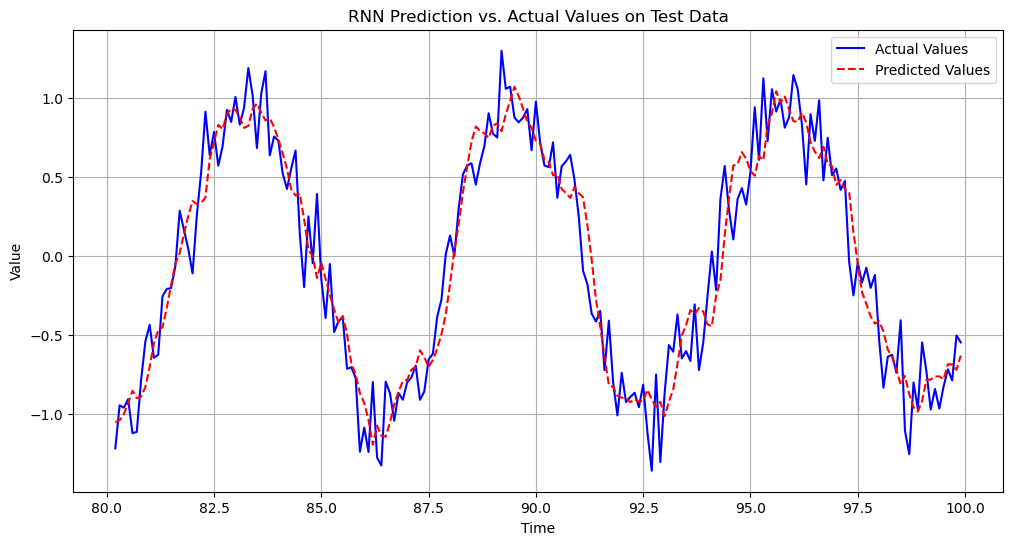

Input sequence (last 10 values): [-0.69280946 -0.40366316 -0.530022   -0.6958833  -0.605892   -0.6911192
 -0.595226   -0.52053875 -0.56900173 -0.3734856 ]
Predicted next value: -0.4609
Actual next value: -0.4035


In [23]:
# We don't need to track gradients during evaluation, so we use "torch.no_grad()"
with torch.no_grad():
    # Make predictions on the test data.
    test_predictions = model(test_inputs)
    
    # Calculate the loss on the test set.
    test_loss = criterion(test_predictions, test_targets)

    # Round the test_loss to four decimal places
    print(f"\nTest Loss: {test_loss.item():.4f}")
    
    # Let's plot our predictions against the actual values.
    # First we move the tensors back to the CPU for plotting.
    test_predictions_cpu = test_predictions.cpu().numpy()
    test_targets_cpu = test_targets.cpu().numpy()

    # We scale the data back to its original values.
    test_predictions_cpu = inverse_normalize_data(test_predictions_cpu)
    test_targets_cpu = inverse_normalize_data(test_targets)

    # We need to create a time axis for our plot.
    # We'll use the original time_steps and start from where the test data begins.
    time_axis_test = x_data[train_size + sequence_length:]

    plt.figure(figsize=(12, 6))
    plt.plot(time_axis_test, test_targets_cpu, label="Actual Values", color="blue")
    plt.plot(time_axis_test, test_predictions_cpu, label="Predicted Values", color="red", linestyle="--")
    plt.title("RNN Prediction vs. Actual Values on Test Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

# We can also make a single prediction on a new sequence
# We grab the last sequence from our original data that the model hasn't seen.
# We unsqueeze it to make it a batch of size 1.
new_input_sequence = input_sequences[-1:].to(device)

# Make a prediction.
with torch.no_grad():
    predicted_next_value = model(new_input_sequence)

# Print the result.
print(f"Input sequence (last 10 values): {new_input_sequence.cpu().numpy().flatten()}")
print(f"Predicted next value: {predicted_next_value.item():.4f}")
print(f"Actual next value: {targets[-1].item():.4f}")